In [13]:
import matplotlib.pyplot as plt 
import numpy as np

from astropy.table import Table

from astropy import units as u
from astropy.coordinates import SkyCoord

from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Tcmb0=2.725)

In [21]:
# dimensionless hubble parameter
h = 0.7

# Data

### Group catalog from Yang+07

In [14]:
grps = Table.read("./data/group_DR7/modelA_group", format = 'ascii')

# Assign column names
grps['col1'].name = 'id'
grps['col2'].name = 'RA'
grps['col3'].name = 'dec'
grps['col4'].name = 'z'
grps['col5'].name = 'L'
grps['col6'].name = 'sm'
grps['col7'].name = 'hm1'
grps['col8'].name = 'hm2'
grps['col9'].name = 'mean_sep1'
grps['col10'].name = 'mean_sep2'
grps['col11'].name = 'f_edge'
grps['col12'].name = 'ID1'
grps['col13'].name = 'ID2'

# mask - halo masses more massive than 5e12 solar masses
mask_m = (grps['hm1'] > np.log10(5e12))
# mask - redshift at 0.015 < z < 0.055
mask_z = (grps['z'] > 0.015) & (grps['z'] < 0.055)
# mask - RA & Dec within the survey area
mask_coord = ((grps['RA'] < 70) | (grps['RA'] > 290)) & ((grps['dec'] < 5) & (grps['dec'] > -5))
## final mask satisfying the above conditions
mask_grp = mask_m & mask_z & mask_coord

# final samples after masking
grps = grps[mask_grp]

In [15]:
# number of group samples
len(grps)

91

In [16]:
# ra, dec, redshift, distance of group samples
ra_grp = grps['RA']
dec_grp = grps['dec']
zz_grp = grps['z']
dist_grp = cosmo.comoving_distance(zz_grp).value # Mpc

# transform (ra, dec, distance) into cartesian (x, y, z) for cosmic web calculation
coords = SkyCoord(ra = ra_grp * u.degree, dec = dec_grp * u.degree, distance = dist_grp * u.Mpc)

x_grp = coords.cartesian.x
y_grp = coords.cartesian.y
z_grp = coords.cartesian.z

### Galaxies from Bottrell+19

In [17]:
cat = Table.read("./data/s82grfn.fit")

In [6]:
# ra, dec, redshift, distance of galaxy samples
ra_gal = cat['RAJ2000'].value
dec_gal = cat['DEJ2000'].value
zz_gal = cat['z'].value

dist_gal = cosmo.comoving_distance(zz_gal).value # Mpc

# transform (ra, dec, distance) into cartesian (x, y, z) for cosmic web calculation
coords_gal = SkyCoord(ra = ra_gal * u.degree, dec = dec_gal * u.degree, distance = dist_gal * u.Mpc)

x_gal = coords_gal.cartesian.x
y_gal = coords_gal.cartesian.y
z_gal = coords_gal.cartesian.z

# Comic Web Indentification

In [7]:
# import customized util functions
from utils.mistree import construct_mst, get_graph_degree, get_branch_index, get_branch_end_index

In [8]:
# set the nearest neighbor number k
k_neighbours=20
# number of groups (nodes)
number_of_nodes = len(x_grp)

## MST algorithms
edge_length, edge_x, edge_y, edge_z, edge_index = construct_mst(x_grp, y_grp, z_grp, k_neighbours)
degree, edge_degree = get_graph_degree(edge_index, number_of_nodes)
branch_index, rejected_branch_index = get_branch_index(edge_index, edge_degree)

### 1. Cluster

In [10]:
# member galaxy catalog matched with Yang+07 groups
matched_ids = Table.read('./data/galaxy_DR7/SDSS7_S82_matched_id.cat', format = 'ascii')

## match the Bottrell galaxy catalog (cat) with member galaxy catalog from Yang+07 (matched_ids)
mask_cluster = np.isin(cat['recno'], matched_ids['s82_recno'])

In [11]:
# the number of cluster galaxies
sum(mask_cluster)

885

### 2. Filament

In [23]:
from scipy import spatial

In [24]:
# calculate the KDT tree using the location of groups (nodes).
tree = spatial.cKDTree(np.array([x_grp, y_grp, z_grp]).T)

# distance to the k-th nearest node and its pair. Setting k = 2
d_node = tree.query(np.array([x_gal, y_gal, z_gal]).T, k = 2)

In [22]:
# find filament galaxy candidates whose edge length is shorter than 5.75/h
mask_link = edge_length < 5.75 / h
# the index of the filament galaxy candidates
grp_index = np.where(mask_link)[0]

mask_cand1 = np.isin(d_node[1][:, 0], grp_index)
mask_cand2 = np.isin(d_node[1][:, 1], grp_index)
mask_cand = mask_cand1 & mask_cand2

In [25]:
# position vector of the "GROUP" galaxies
P1 = np.array([x_grp[d_node[1][:, 0]], y_grp[d_node[1][:, 0]], z_grp[d_node[1][:, 0]]]).T
P2 = np.array([x_grp[d_node[1][:, 1]], y_grp[d_node[1][:, 1]], z_grp[d_node[1][:, 1]]]).T

Pgal = np.array([x_gal, y_gal, z_gal]).T

In [27]:
# distance between filament galaxy candidates and group galaxies
d_fil = np.linalg.norm(
    np.cross(P2 - Pgal, P1 - Pgal)
    , axis = 1) / np.linalg.norm(P2 - P1, axis = 1) 

In [28]:
# the final mask for the filament galaxies should satisfy:
# (1) mask_cand: the edge length should be shorter than 5.75/h
# (2) ~mask_cluster: should not be included in the cluster candidates
# (3) d_fil < 4.12/h: filament distance condition
mask_filament = mask_cand & ~mask_cluster & (d_fil < 4.12 / h)

### 3. Tendrils

In [29]:
k_neighbours=20
# remaining galaxies excluding cluster and filament galaxies
mask_remain = (~mask_filament & ~mask_cluster).copy()
# number of nodes (remaining "GALAXY" in this case)
number_of_nodes_t = len(x_gal[mask_remain])

## MST algorithms
edge_length_t, edge_x_t, edge_y_t, edge_z_t, edge_index_t = construct_mst(x_gal[mask_remain], y_gal[mask_remain], z_gal[mask_remain], k_neighbours)
degree_t, edge_degree_t = get_graph_degree(edge_index_t, number_of_nodes_t)
branch_index_t, rejected_branch_index_t = get_branch_index(edge_index_t, edge_degree_t)

In [30]:
# find tendril galaxy candidates whose edge length is shorter than 3.0/h
mask_link_t = edge_length_t < 3.0 / h 

#flag mask for finding tendril galaxies
mask_tendril = np.zeros(shape = len(mask_cluster), dtype = bool)
## (1)  the edge length should be shorter than 3.0/h
mask_tendril[
    np.where(mask_remain)[0][edge_index_t[0][mask_link_t]]
] = True

mask_tendril[
    np.where(mask_remain)[0][edge_index_t[1][mask_link_t]]
] = True

# (2) ~mask_cluster: should not be included in the cluster candidates
mask_tendril[mask_cluster] = False
# (3) ~mask_cluster: should not be included in the filament candidates
mask_tendril[mask_filament] = False

### 4. Void

In [31]:
# mask_void: all the remaining galaxies after excluding cluter, filament, and tendril galaxies
mask_void = ~mask_cluster & ~mask_filament & ~mask_tendril

# Visualization

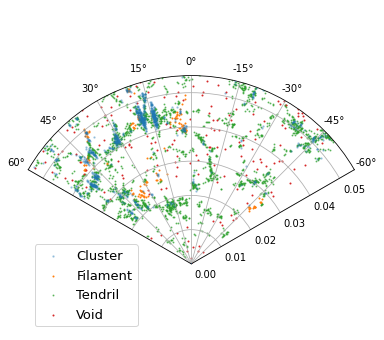

In [38]:
fig, ax = plt.subplots(figsize = (8, 6), subplot_kw={'projection': 'polar'})


theta_grp = ra_grp * np.pi / 180
### location of groups
# ax.scatter(theta_grp, zz_grp, s = 10, zorder = 5, color = 'black', alpha = .5)

theta_gal = ra_gal * np.pi / 180
### location of galaxies
# ax.scatter(theta_gal, zz_gal, s = 1, label = 'all', color = 'gray')

ax.scatter(theta_gal[mask_cluster], zz_gal[mask_cluster], s = 2, label = 'Cluster', zorder = 3, alpha = .3)
ax.scatter(theta_gal[mask_filament], zz_gal[mask_filament], s = 1, label = 'Filament')
ax.scatter(theta_gal[mask_tendril], zz_gal[mask_tendril], s = 1, label = 'Tendril', alpha = .6)
ax.scatter(theta_gal[mask_void], zz_gal[mask_void], s = 1, label = 'Void')


ax.set_thetalim(-np.pi/3, np.pi/3)
ax.set_rlim(0, 0.055)

# ax.set_ylabel('redshift', fontsize = 15)
# ax.yaxis.set_label_position('right')
# ax.set_xlabel('RA [deg]', fontsize = 15)

ax.legend(fontsize = 13)

ax.set_theta_zero_location("N")

# Density

In [39]:
# calculate sigma3 (density from the 3-th nearest neighbours)
tree_gals = spatial.cKDTree(np.array([x_gal, y_gal, z_gal]).T)
d_node_gals = tree.query(np.array([x_gal, y_gal, z_gal]).T, k = 3)

sig3 = 3 * np.pi**(-1) * (d_node_gals[0][:, 2])**(-2)
sig3 = np.log10(sig3)

Text(0, 0.5, 'Frequency')

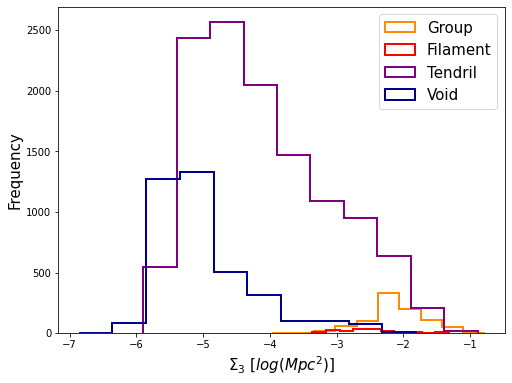

In [40]:
fig, ax = plt.subplots(figsize = (8, 6))

ax.hist(sig3[mask_cluster], color = 'darkorange', histtype = 'step', density = False, linewidth = 2, label = 'Group')
ax.hist(sig3[mask_filament], color = 'red', histtype = 'step', density = False, linewidth = 2, label = 'Filament')
ax.hist(sig3[mask_tendril], color = 'purple', histtype = 'step', density = False, linewidth = 2, label = 'Tendril')
ax.hist(sig3[mask_void], color = 'darkblue', histtype = 'step', density = False, linewidth = 2, label = 'Void')

ax.legend(fontsize = 15)

ax.set_xlabel(r'$\Sigma_{3}$ $[log(Mpc^{2})]$', fontsize = 15)
ax.set_ylabel('Frequency', fontsize = 15)

In [24]:
# theta_grp = ra_grp * np.pi / 180

# fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})

# # mask_link = edge_length < 5.75 / 0.7
# mask_link = edge_length < 15 / 0.7

# ax.scatter(theta_grp, zz_grp, s = 10, zorder = 2, color = 'r')

# ax.plot([theta_grp[edge_index[0][mask_link]], theta_grp[edge_index[1][mask_link]]],
#         [zz_grp[edge_index[0][mask_link]], zz_grp[edge_index[1][mask_link]]],
#          color = 'k' )

# ax.set_thetalim(-np.pi/3, np.pi/3)

# ax.set_xlabel('redshift', fontsize = 15)
# ax.set_ylabel('RA [deg]', fontsize = 15)

# # fig.savefig('result.png')